
# Alpha Factor Evaluation

This notebook illustrates the following steps:
- Evaluate the predictive content of your financial features with respect to the 1-day forward returns using several metrics, including:
- the information coefficient (i.e., the Spearman rank correlation)
- the mutual information
- the LightGBM feature importance, computed by training a gradient boosting model with default settings on the first nine years of data 
- SHAP values computed from the LightGBM model (see resources)
- Alphalens quantile-based return spreads (see resources)

These different metrics will yield different and even conflicting answers. Take some time to think about why this is the case, and which approach(es) would likely be most effective when aiming to select the most predictive features?  

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

pd.set_option('display.max_columns', None)

In [4]:
MONTH = 21
YEAR = 252

## Load Data

In [5]:
DATA_STORE = '../data/stock_prices.h5'

In [6]:
data =  pd.read_hdf(DATA_STORE).dropna()

## Factor Correlation

Which features are most alike in terms of their (rank) correlation?

In [7]:
factors_list = ['dollar_volume', 'return_1_days', 'return_3_days', 'return_5_days',
       'return_10_days', 'return_21_days', 'return_42_days', 'return_63_days',
       'return_126_days', 'return_252_days', 'BBands_high',
       'BBands_mid', 'BBands_low', 'BB_revert', 'ADX', 'MACD', 'BOP', 'MFI',
       'RSI', 'ADOSC', 'OBV', 'ALPHA_21', 'Mkt-RF_21', 'SMB_21', 'HML_21',
       'RMW_21', 'CMA_21', 'ALPHA_63', 'Mkt-RF_63', 'SMB_63', 'HML_63',
       'RMW_63', 'CMA_63', 'month', 'weekday']

In [8]:
corr_matrix = data[factors_list].corr('spearman')

<AxesSubplot:>

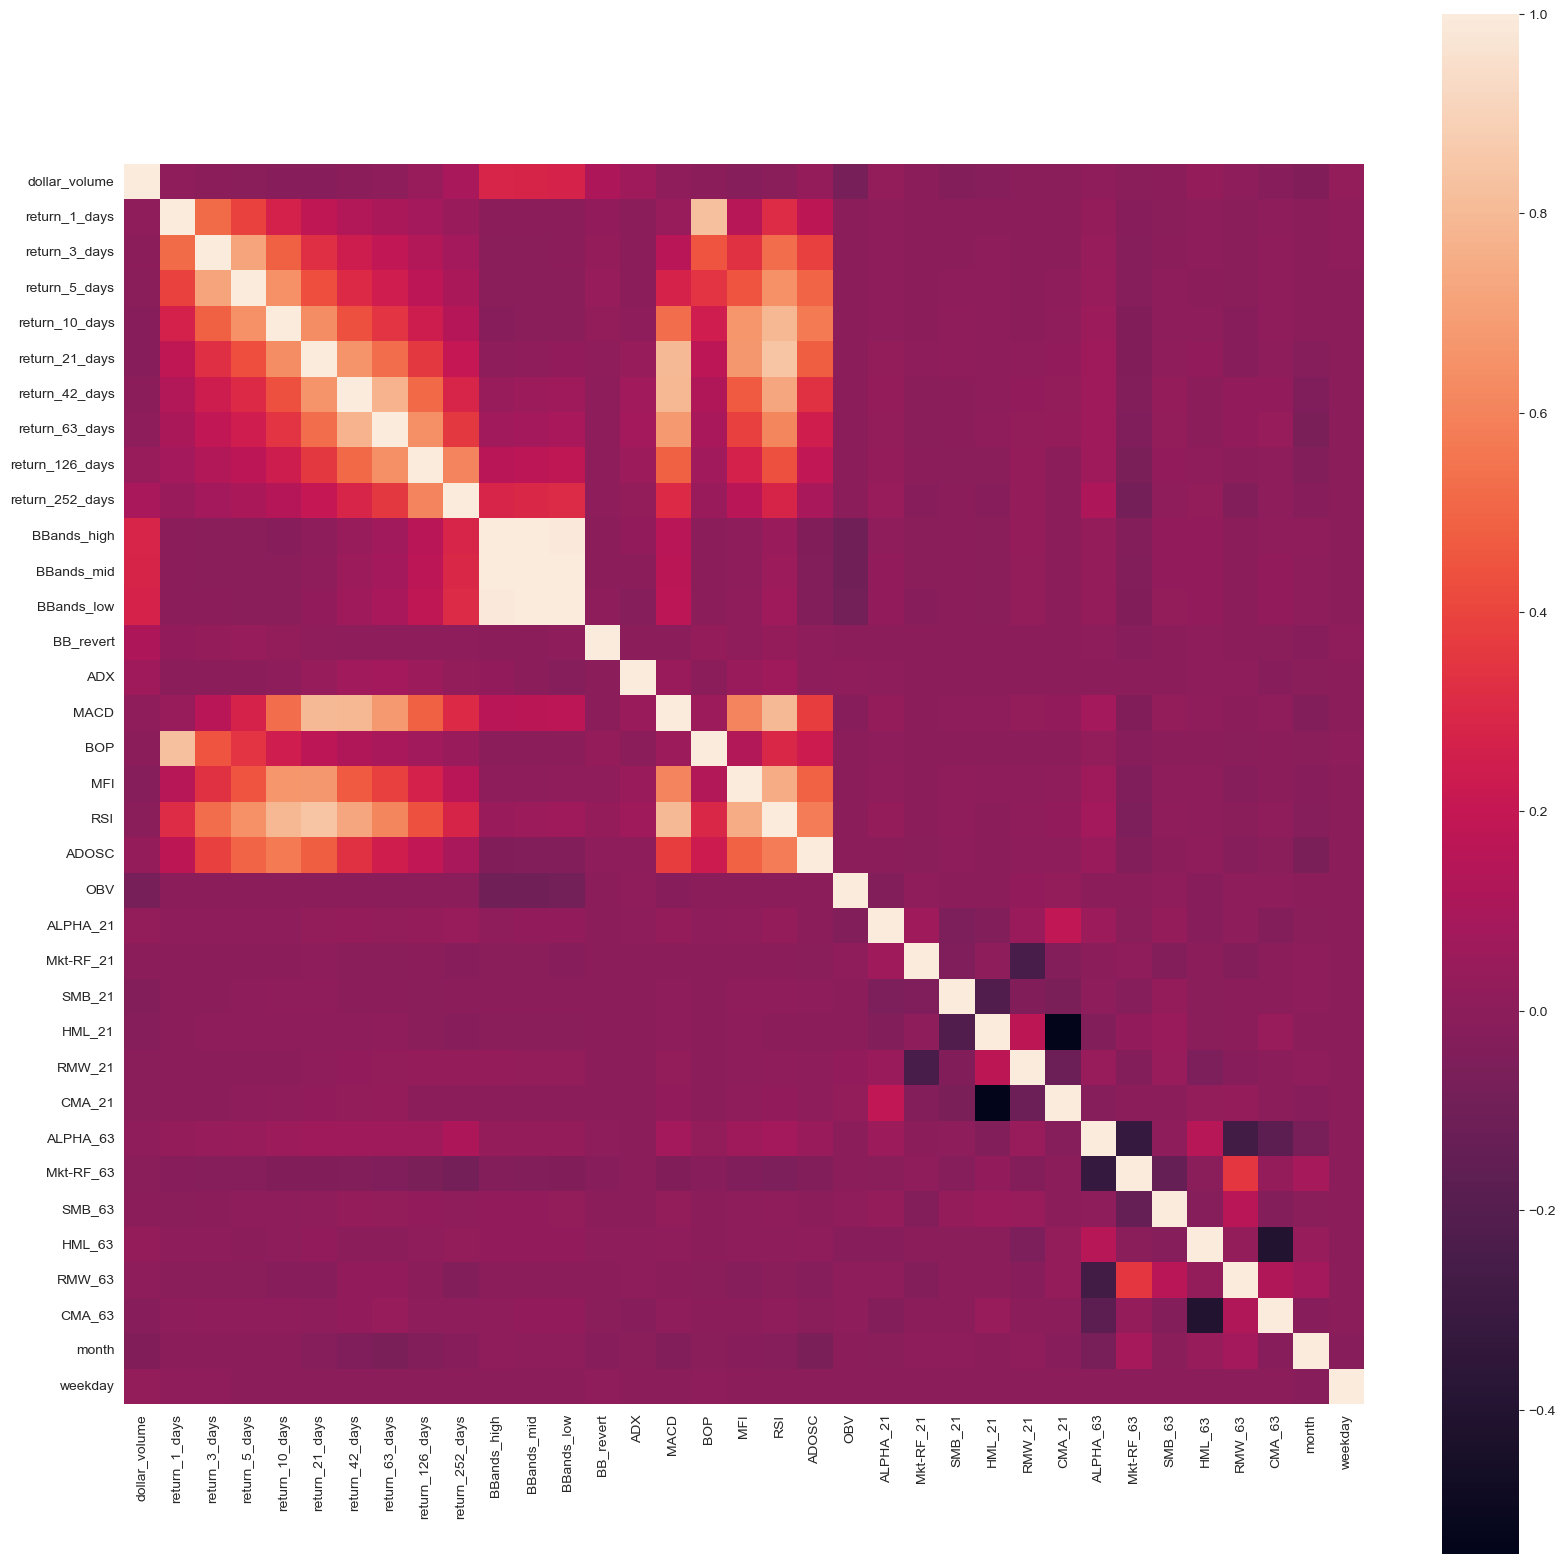

In [9]:
plt.subplots(figsize=(20,20))
sns.heatmap(corr_matrix, square=True)

In [10]:
sorted_mat_stg1 = corr_matrix.unstack().reset_index()\
                    .rename(columns={'level_0':'a','level_1':'b',0:'rho'})

# remove a == b (self correlations)
sorted_mat_stg2 = sorted_mat_stg1[sorted_mat_stg1['a']!=sorted_mat_stg1['b']]

# sort matrix
sorted_mat_stg3 = sorted_mat_stg2.sort_values(by='rho', ascending=False).reset_index(drop=True)

# keep the even numbers because the duplicates would be stacked on top of one another
sorted_mat = sorted_mat_stg3.iloc[sorted_mat_stg3.index % 2 ==0]

sorted_mat.head(30)

,a,b,rho
0,BBands_mid,BBands_high,0.998151
2,BBands_low,BBands_mid,0.997107
4,BBands_low,BBands_high,0.990892
6,RSI,return_21_days,0.840889
8,return_1_days,BOP,0.819061
10,MACD,RSI,0.796050
12,MACD,return_21_days,0.795856
14,return_42_days,MACD,0.790676
16,RSI,return_10_days,0.789408
18,return_63_days,return_42_days,0.774515


## Forward return correlation

Which features are most correlated with the forward returns?

In [11]:
fwd_corr = data.drop(['return_fwd'], axis=1).corrwith(data.return_fwd, method='spearman')

In [12]:
fwd_corr.sort_values(ascending=False)

ALPHA_63           0.038097
HML_63             0.011780
ALPHA_21           0.011284
CMA_63             0.005731
return_126_days    0.003875
HML_21             0.003157
month              0.001786
RMW_21             0.001521
return_252_days    0.000619
OBV                0.000358
Mkt-RF_21         -0.000265
CMA_21            -0.000413
SMB_21            -0.001723
ADX               -0.003115
BB_revert         -0.003327
return_42_days    -0.005072
dollar_volume     -0.005141
BBands_low        -0.005831
BBands_mid        -0.006208
BBands_high       -0.006500
SMB_63            -0.007493
return_63_days    -0.008384
RMW_63            -0.010690
MACD              -0.012711
weekday           -0.017937
Mkt-RF_63         -0.018161
return_21_days    -0.018286
MFI               -0.018628
return_10_days    -0.020097
ADOSC             -0.021004
return_3_days     -0.021526
RSI               -0.022282
return_1_days     -0.024152
BOP               -0.024484
return_5_days     -0.024952
dtype: float64

In [13]:
fwd_corr.to_csv('../data/forward_correlations.csv')

## Mutual Information

Let's estimate the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the forward returns for a non-linear measure of dependency (see scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) for references on computation.

> The `mutual_info_regression` can take a while, reduce the sample size as indicated below to speed up things.

In [14]:
mir_sample = data.dropna().sample(100000)

In [15]:
mir = mutual_info_regression(X=mir_sample[factors_list],
                                   y=mir_sample.return_fwd,
                                   discrete_features=[
                                       -1 #weekday
                                       ,-2 #month 
                                       ,-22 #BB_revert
                                   ]
                                   )

In [16]:
mutual_info = pd.Series(mir, index=mir_sample[factors_list].columns)
mutual_info

dollar_volume      0.005207
return_1_days      0.045621
return_3_days      0.042666
return_5_days      0.047729
return_10_days     0.041623
return_21_days     0.051285
return_42_days     0.052166
return_63_days     0.055022
return_126_days    0.051883
return_252_days    0.045316
BBands_high        0.034957
BBands_mid         0.039884
BBands_low         0.045553
BB_revert          0.000000
ADX                0.003515
MACD               0.016821
BOP                0.000000
MFI                0.008034
RSI                0.019756
ADOSC              0.007154
OBV                0.028278
ALPHA_21           0.000735
Mkt-RF_21          0.005895
SMB_21             0.005754
HML_21             0.005903
RMW_21             0.002956
CMA_21             0.001061
ALPHA_63           0.011841
Mkt-RF_63          0.000261
SMB_63             0.009944
HML_63             0.004618
RMW_63             0.000000
CMA_63             0.012445
month              0.004512
weekday            0.000000
dtype: float64

In [17]:
mutual_info.to_csv('../data/mutual_info.csv')

## LightGBM Feature Importance

There will be more information on using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) in Milestone 3.

### Custom Time-Series Cross-Validation

See an example of how the `MultipleTimeSeriesCV` generates sequential, overlapping time periods for training and test in cells 11-13 [here](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/07_linear_models/05_predicting_stock_returns_with_linear_regression.ipynb).

In [18]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        """Generate the positional indices for the train-test splits for each fold"""
        unique_dates = X.index.get_level_values(self.date_idx).unique() # get unique dates
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            # create train/test start and end indices
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

### Custom Metric for Early Stopping

We can customize how LightGBM measures cross-validation progress, and will use the information coefficient. See LightGBM [docs](https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

> Keep in mind that early-stopping introduces lookahead bias, so do not use this to select between different model.

In [19]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True # whether to maximize or minimize the metric
    metric_name = 'ic'
    ic = spearmanr(preds, train_data.get_label())[0]
    return metric_name, ic, is_higher_better 

### CV Parameters

In [20]:
categoricals = ['BB_revert','month', 'weekday']

In [21]:
train_length = 3 * YEAR
test_length = YEAR
n_splits = 1

In [22]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              learning_rate=0.01,
#               device='gpu', # uncomment if using GPU
#               max_bins=63,  # uncomment if using GPU
              metric='None')

In [23]:
num_boost_round = 5000

### Create binary Datasets

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html#lightgbm.Dataset) on the `lgb.Dataset`.

In [24]:
lgb_data = lgb.Dataset(data=data[factors_list],
                       label=data['return_fwd'],
                       categorical_feature=categoricals,
                       free_raw_data=False)

In [25]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

### Cross-validation loop

In [27]:
for train_idx, test_idx in cv.split(X=data[factors_list]):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model('lgb_model.txt')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.178116	valid's ic: 0.0233712
[200]	train's ic: 0.200591	valid's ic: 0.0437015
[300]	train's ic: 0.219201	valid's ic: 0.0491872
[400]	train's ic: 0.233603	valid's ic: 0.0488626
[500]	train's ic: 0.242878	valid's ic: 0.0476481
[600]	train's ic: 0.25029	valid's ic: 0.0452799
[700]	train's ic: 0.256547	valid's ic: 0.0444512
[800]	train's ic: 0.261966	valid's ic: 0.044987
Early stopping, best iteration is:
[320]	train's ic: 0.22218	valid's ic: 0.0502513


We can persist the model to generate predictions later:

In [28]:
model = lgb.Booster(model_file='lgb_model.txt')

### Generate and evaluate predictions

In [30]:
# select test features and label
test_set = data.iloc[test_idx, :]
X_test = test_set.loc[:, model.feature_name()]
y_test = test_set.loc[:, 'return_fwd']

# make predictions
y_pred = model.predict(X_test)
cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)

# compute daily correlation
by_day = cv_preds.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_std = ic_by_day.std()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
print(f'Overall IC: {ic:6.2%} | Average Daily IC: {daily_ic_mean: 6.2%} | Coefficient of Variation for daily IC: {daily_ic_std/daily_ic_mean: 5.2} | Median Daily IC: {daily_ic_median: 6.2%}')

Overall IC:  5.03% | Average Daily IC:  4.13% | Coefficient of Variation for daily IC:   3.6 | Median Daily IC:  2.73%


While the daily average of the IC is positive at 0.027, it is also quite volatile. In other words, predictions will do quite poorly occasionally (and much better otherwise).

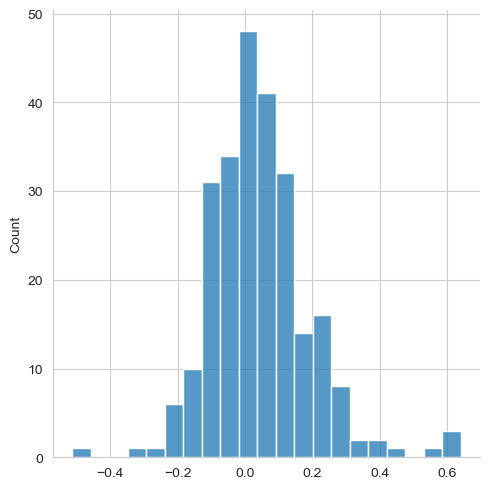

In [31]:
sns.displot(ic_by_day);

Higher momemts (Skew and Kurtosis) confirm that, while only slightly negatively skewed, but has significantly fatter tails than a normal distribution (pandas uses [Fisher's definition](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.kurtosis.html)).

In [32]:
pd.Series({'Mean': ic_by_day.mean(), 
           'Std. Dev': ic_by_day.std(), 
           'Median': ic_by_day.median(), 
           'Skew': ic_by_day.skew(), 
           'Kurtosis': ic_by_day.kurtosis()}).apply(lambda x: f'{x:.4f}')

Mean        0.0413
Std. Dev    0.1475
Median      0.0273
Skew        0.7716
Kurtosis    2.7879
dtype: object

### Compute Feature Importance

In [33]:
def get_fi(model):
    """Compute LightGBM feature imporance"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [34]:
fi = get_fi(model)
fi.to_csv('feature_importance.csv')

In [35]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

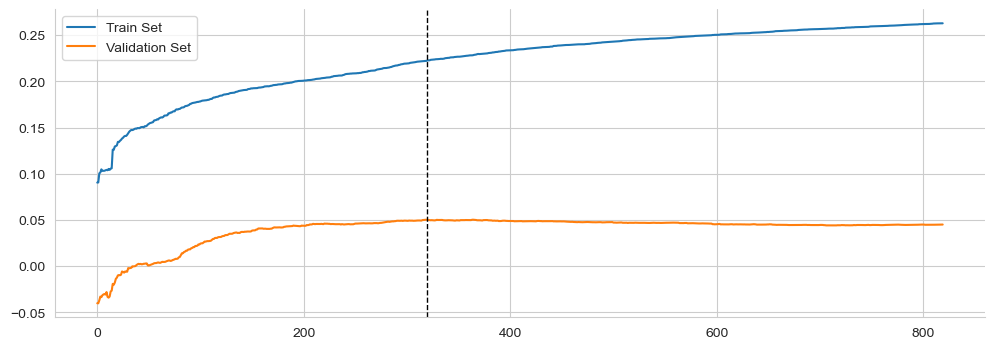

In [36]:
ax = cv_result.plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)
sns.despine();

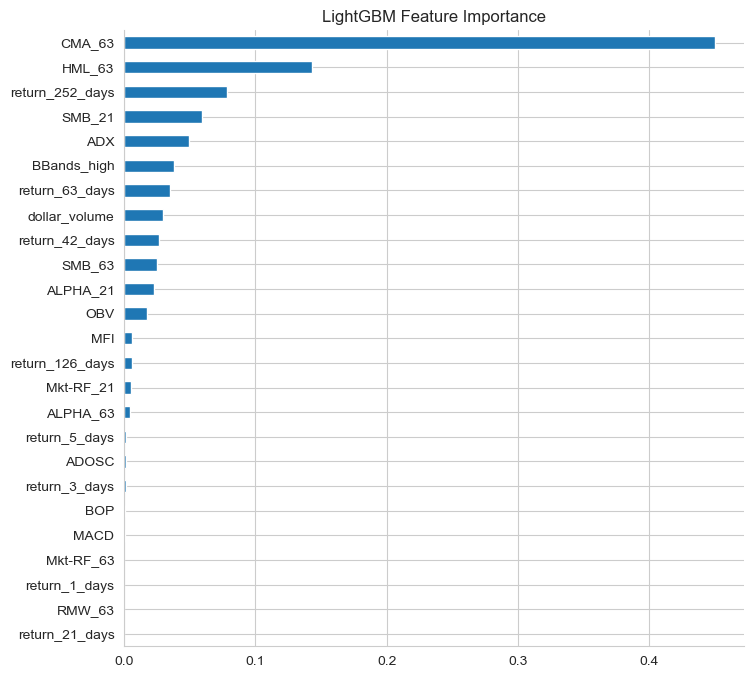

In [37]:
fi.drop(categoricals).nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

## SHAP Values

See SHAP Values [GitHub repo](https://github.com/slundberg/shap) for docs and links to papers.

In [38]:
shap.initjs()

In [39]:
model = lgb.Booster(model_file='lgb_model.txt')

In [40]:
explainer = shap.TreeExplainer(model)

In [41]:
# workaround for SHAP version 0.35: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [43]:
shap_values = explainer.shap_values(data.iloc[test_idx, :].loc[:, model.feature_name()])

In [44]:
np.save('shap_values.npy', shap_values)

In [45]:
shap_values = np.load('shap_values.npy')

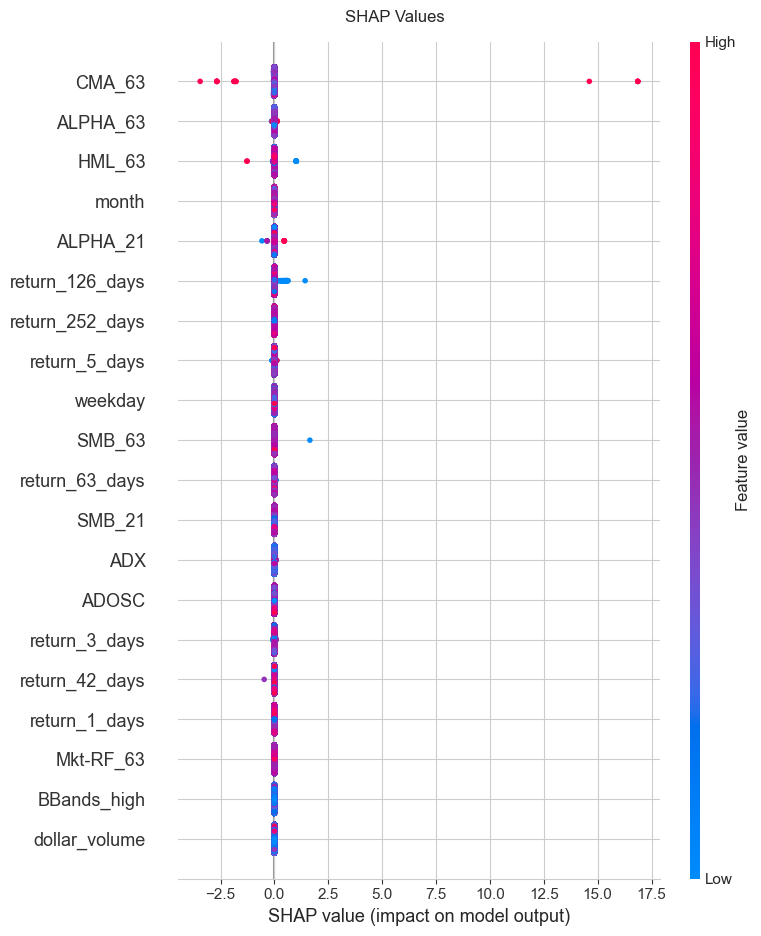

In [47]:
shap.summary_plot(shap_values,
                  data
                  .iloc[test_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [49]:
shap_values = pd.DataFrame(shap_values, columns=factors_list)

In [50]:
shap_summary = np.abs(shap_values).mean()
shap_summary /= shap_summary.sum()

In [51]:
shap_summary.nlargest(20)

CMA_63             0.329569
ALPHA_63           0.101601
HML_63             0.087801
month              0.060723
ALPHA_21           0.053095
return_126_days    0.044578
return_252_days    0.033557
return_5_days      0.032309
weekday            0.028481
SMB_63             0.024782
return_63_days     0.024353
SMB_21             0.021682
ADX                0.020132
ADOSC              0.015608
return_3_days      0.013414
return_42_days     0.012197
return_1_days      0.011625
Mkt-RF_63          0.011566
BBands_high        0.011415
dollar_volume      0.011267
dtype: float64

In [52]:
shap_summary.to_csv('shap_values.csv')

## Comparison

In [56]:
mi = pd.read_csv('../data/mutual_info.csv', index_col=0, squeeze=True)
fwd_corr = pd.read_csv('../data/forward_correlations.csv', index_col=0, squeeze=True)

In [57]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

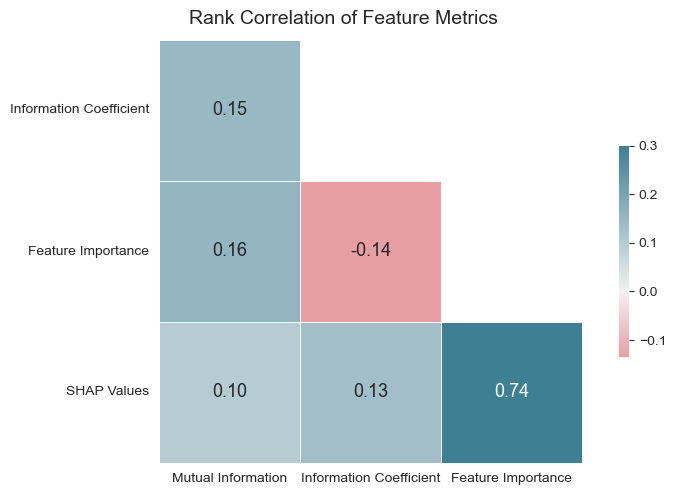

In [58]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}

corr = stats.assign(**cols).corr('spearman')

mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask,
            cmap=cmap,
            vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True, fmt='.2f',
            annot_kws={"size": 13})

plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.92)

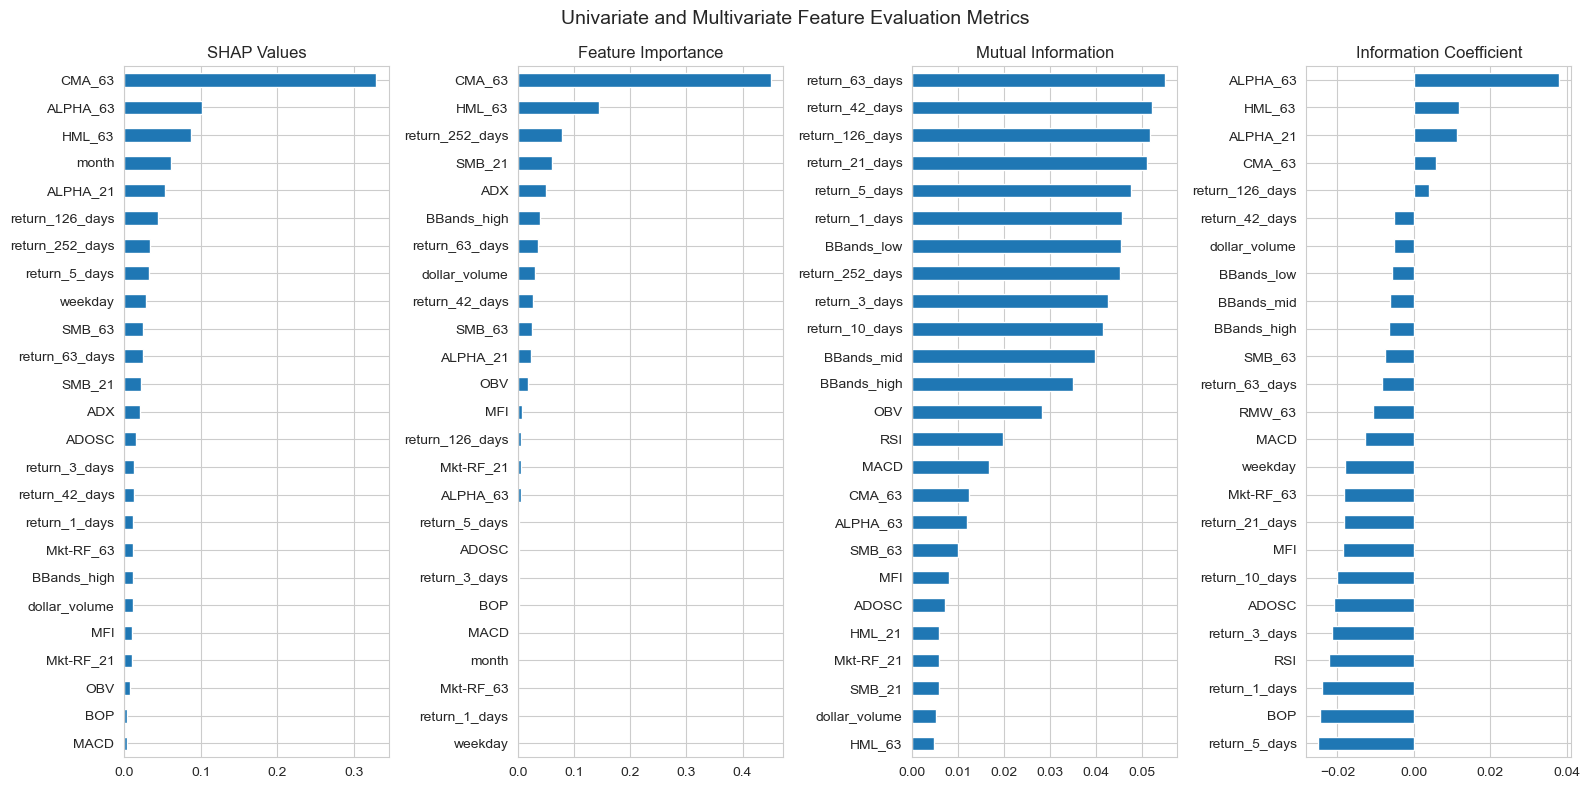

In [59]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91);

In [60]:
top_ranked = stats.drop('Mutual Information', axis=1).abs().rank(ascending=False).mean(1)

In [61]:
top_ranked.to_csv('top_features.csv')

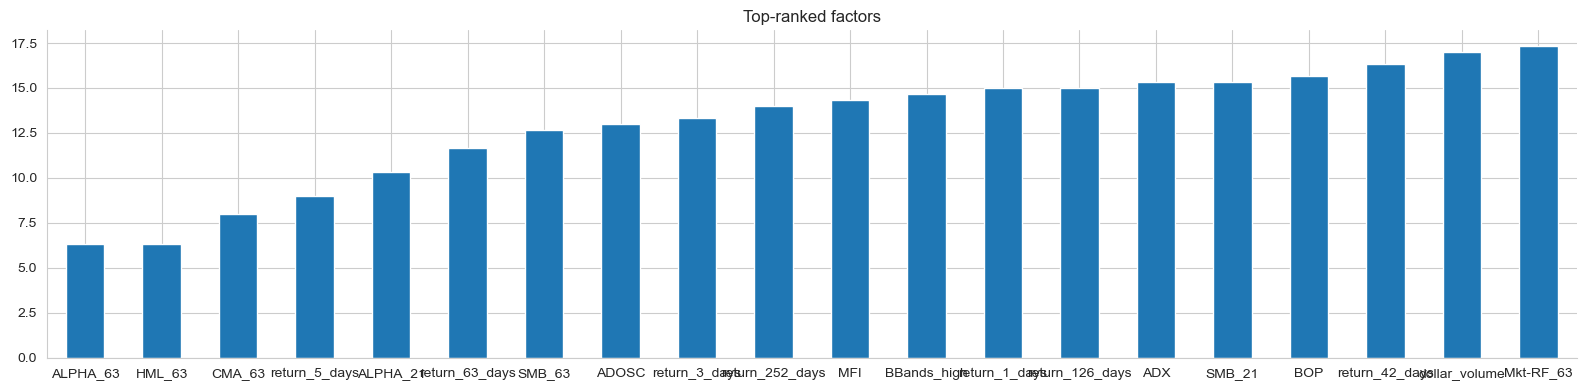

In [62]:
top_ranked.drop(categoricals).nsmallest(20).plot.bar(figsize=(16, 4), rot=0, title='Top-ranked factors')
sns.despine()
plt.tight_layout();

## Alphalens Analysis

Alphalens is a Python Library (originally developed by Quantopian) for performance analysis of predictive (alpha) stock factors. Alphalens works great with the Zipline open source backtesting library, and Pyfolio which provides performance and risk analysis of financial portfolios. 

The main function of Alphalens is to surface the most relevant statistics and plots about an alpha factor, including:

- Returns Analysis
- Information Coefficient Analysis
- Turnover Analysis
- Grouped Analysis

See Alphalens [docs](https://alphalens.ml4trading.io) and [example notebooks](https://github.com/stefan-jansen/alphalens-reloaded/tree/master/alphalens/examples) for additional detail.

In [63]:
tickers = data.index.unique('ticker')

### Get trade prices

We need market prices for the relevant period:

In [71]:
def get_trade_prices(tickers):
    return (pd.read_hdf('../data/stock_data.h5', 'data')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [72]:
trade_prices = get_trade_prices(tickers)

In [73]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 235 entries, A to HSH
dtypes: float64(235)
memory usage: 5.4 MB


### Select factor

We also need the factor signals that we want to evaluate:

In [83]:
alpha = 'CMA_63'

In [84]:
factor = (data[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

### Generate Alphalens input data

With a signal and pricing data creating a factor "tear sheet" is a two step process:
1. Bring data into the right format
2. Select desired tearsheet.

In [87]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.12,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 12.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 567434 entries, (Timestamp('2007-04-03 00:00:00+0000', tz='UTC', freq='C'), 'AAL') to (Timestamp('2016-12-30 00:00:00+0000', tz='UTC', freq='C'), 'HRB')
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               567434 non-null  float64
 1   5D               567434 non-null  float64
 2   10D              567434 non-null  float64
 3   factor           567434 non-null  float64
 4   factor_quantile  567434 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 23.8+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-160.0,3.5,-0.238935,2.820278,115035,20.272842
2,-72.0,31.0,-0.097338,1.730995,113488,20.000211
3,-52.0,68.0,-0.013388,1.562597,113062,19.925137
4,-32.0,121.5,0.071171,2.082589,112805,19.879845
5,-15.5,274.0,0.215094,3.574607,113044,19.921964


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.025,-0.001,0.004
beta,-0.011,-0.011,-0.003
Mean Period Wise Return Top Quantile (bps),-1.345,-0.616,-0.200
Mean Period Wise Return Bottom Quantile (bps),2.155,0.490,0.071
Mean Period Wise Spread (bps),-3.500,-1.105,-0.269


Information Analysis


,1D,5D,10D
IC Mean,-0.006,-0.004,-0.004
IC Std.,0.136,0.100,0.095
Risk-Adjusted IC,-0.044,-0.037,-0.040
t-stat(IC),-2.202,-1.855,-1.966
p-value(IC),0.028,0.064,0.049
IC Skew,-0.001,0.194,-0.011
IC Kurtosis,4.964,1.640,0.833


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.140,0.310,0.446
Quantile 2 Mean Turnover,0.246,0.461,0.593
Quantile 3 Mean Turnover,0.256,0.468,0.588
Quantile 4 Mean Turnover,0.244,0.463,0.596
Quantile 5 Mean Turnover,0.140,0.315,0.454


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.896,0.694,0.504


<Figure size 640x480 with 0 Axes>

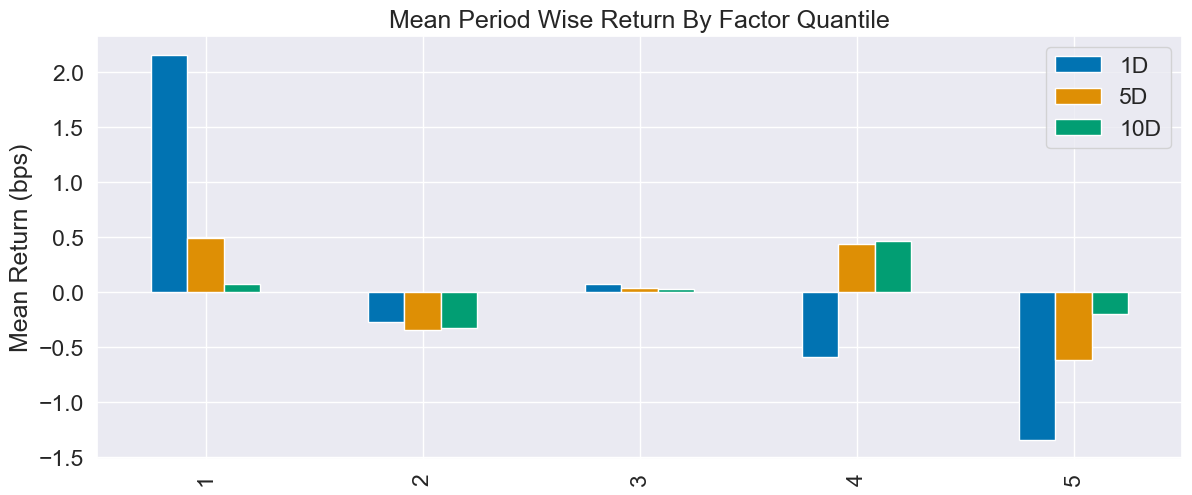

In [88]:
create_summary_tear_sheet(factor_data)